In [1]:
import scanpy as sc
import squidpy as sq
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

/Users/yaochung41/Desktop/spatial-transcriptomic-visum-pipeline/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# read data
adata = sc.read_h5ad("../data/anndata/visium_hne_adata.h5ad")
print(f"Shape of the data: {adata.shape[0]}, and genes: {adata.shape[1]}")

Shape of the data: 2688, and genes: 18078


In [3]:
# calculate QC 
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)


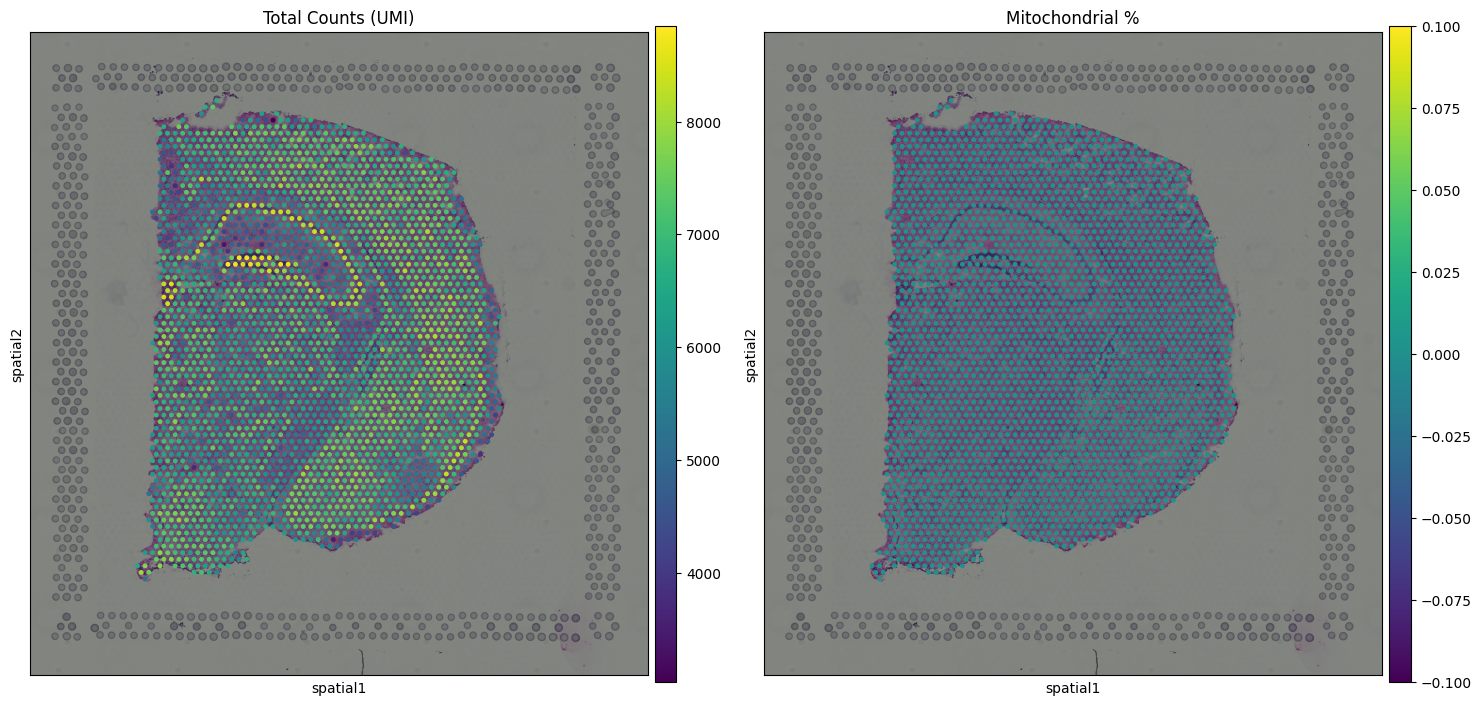

In [4]:
# visualize to see the percentage of mitochondrial genes and total counts
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sq.pl.spatial_scatter(adata, color="total_counts", ax=ax[0], title="Total Counts (UMI)")
sq.pl.spatial_scatter(adata, color="pct_counts_mt", ax=ax[1], title="Mitochondrial %")
plt.tight_layout()
plt.savefig("../results/qc_metrics.png", dpi=300, bbox_inches='tight')

In [5]:
# Double check the calculation of total counts and percentage of mitochondrial genes
print(adata.obs[["total_counts", "pct_counts_mt"]].head())

                    total_counts  pct_counts_mt
AAACAAGTATCTCCCA-1   6510.653320            0.0
AAACAATCTACTAGCA-1   5088.009766            0.0
AAACACCAATAACTGC-1   6495.387695            0.0
AAACAGAGCGACTCCT-1   6092.714355            0.0
AAACCGGGTAGGTACC-1   6469.493164            0.0


In [6]:
# filter spots and genes
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=10)

# filter spots with high percentage of mitochondrial genes
adata = adata[adata.obs["pct_counts_mt"] < 20, :].copy()
print(f"After filtering: {adata.n_obs} spots, {adata.n_vars} genes")

After filtering: 2688 spots, 16957 genes


In [7]:
# normalization
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

adata.raw = adata

/Users/yaochung41/Desktop/spatial-transcriptomic-visum-pipeline/venv/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:88: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


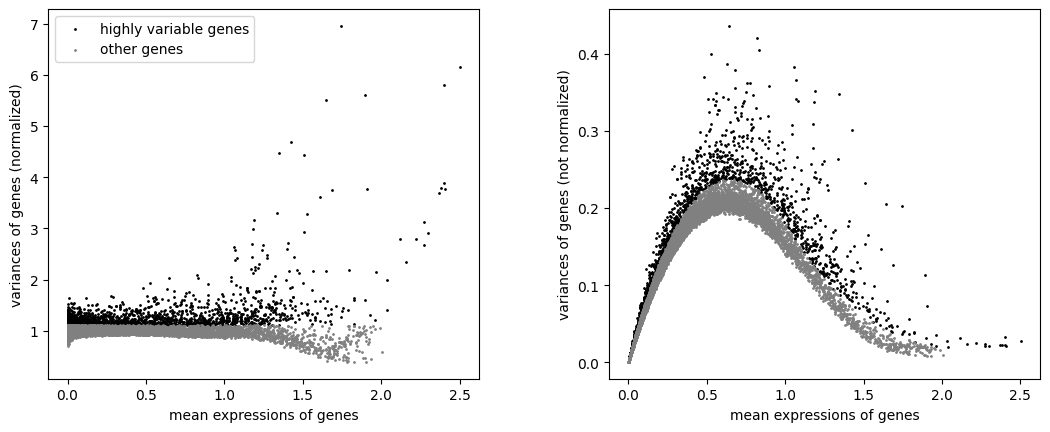

<Figure size 640x480 with 0 Axes>

In [8]:
# achieve high variable genes
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=2000)

sc.pl.highly_variable_genes(adata)

plt.savefig("../results/highly_variable_genes.png", dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# only keep highly variable genes for downstream analysis
adata = adata[:, adata.var.highly_variable].copy()

# scaling unit variance
sc.pp.scale(adata, max_value=10)
print(f"After keeping highly variable genes: {adata.shape[0]} spots, {adata.shape[1]} genes")

After keeping highly variable genes: 2688 spots, 2000 genes


/opt/homebrew/Cellar/python@3.11/3.11.14_3/Frameworks/Python.framework/Versions/3.11/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [10]:
# dimensionality reduction
sc.tl.pca(adata)

# neighbor graph and clustering
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# leiden clustering
sc.tl.leiden(adata, resolution=0.5, key_added="clusters")

# umap
sc.tl.umap(adata)

print(f"Clustering completed. Identified {len(adata.obs['clusters'].unique())} groups.")

/var/folders/90/yg0k6bpj6y16qppdcp0ls66c0000gn/T/ipykernel_22806/1952150891.py:8: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5, key_added="clusters")


Clustering completed. Identified 12 groups.


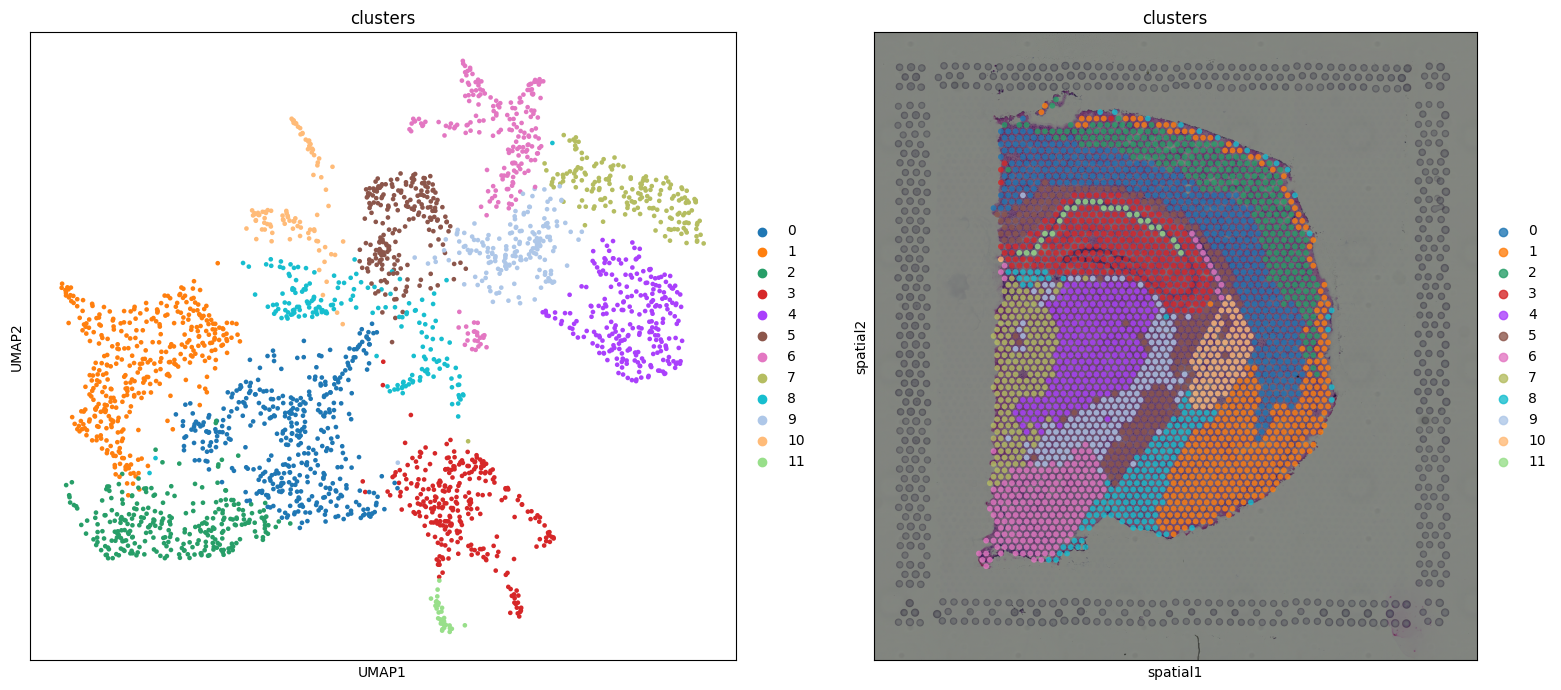

In [11]:
# spatial mapping
# 1. get library_id
lib_id = list(adata.uns["spatial"].keys())[0]

fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# left figure: UMAP clusters
sc.pl.umap(adata, color="clusters", ax=ax[0], show=False)

# right figure: spatial projection (fix parameter names)
try:
    sq.pl.spatial_scatter(
        adata,
        library_id=lib_id,
        color="clusters",
        img=True,
        img_res_key="hires",  
        ax=ax[1],
        alpha=0.8,
        size=1.2
    )
except TypeError:
    sq.pl.spatial_scatter(
        adata,
        library_id=lib_id,
        color="clusters",
        img=True,
        ax=ax[1],
        alpha=0.8,
        size=1.2
    )

plt.tight_layout()
plt.savefig("../results/spatial_clusters.png", dpi=300, bbox_inches='tight')

plt.show()

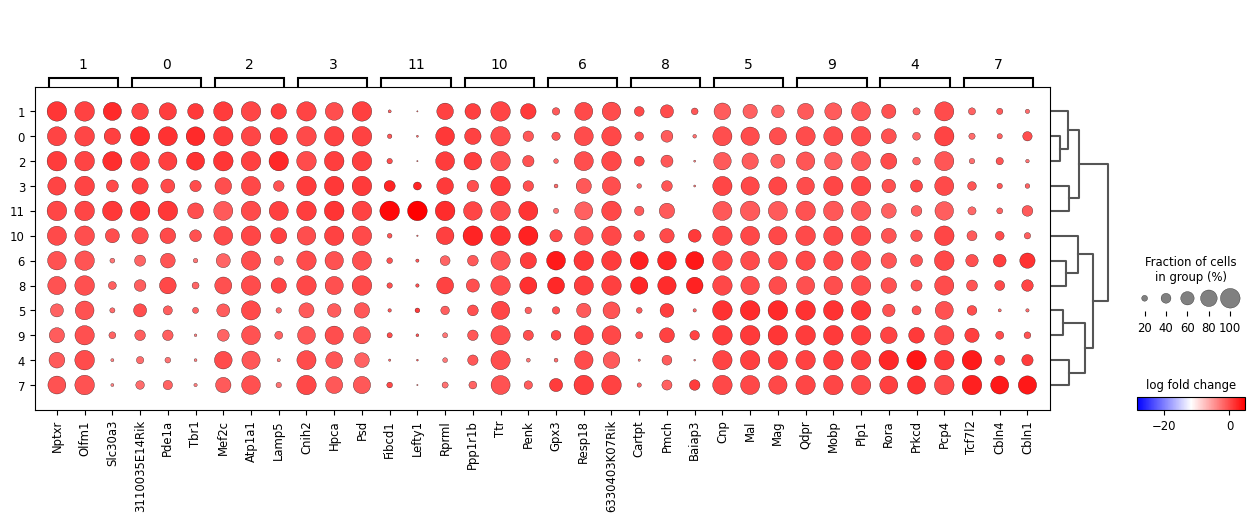

Top 10 marker genes per cluster:
               0         1        2       3       4       5              6  \
0  3110035E14Rik     Nptxr    Mef2c   Cnih2    Rora     Cnp           Gpx3   
1          Pde1a     Olfm1   Atp1a1    Hpca   Prkcd     Mal         Resp18   
2           Tbr1   Slc30a3    Lamp5     Psd    Pcp4     Mag  6330403K07Rik   
3         Hs3st2    Hpcal4    Stx1a   Cabp7  Adarb1    Mobp           Nnat   
4          Ttc9b      Syn2    Cabp1     Ddn  Amotl1   Cryab            Ndn   
5          Dclk1       Ddn  Camk2n1    Ncdn   Ramp3    Plp1         Baiap3   
6  1110008P14Rik       Nov     Nrgn  Camk2a    Pdp1  Cldn11            Gal   
7         Diras2   Neurl1a   Arpp19  Ppp3ca   Ptpn4   Sept4       AW551984   
8           Sv2b  Rasgef1a    Dact2  Tmsb4x   Tnnt1     Mog           Dlk1   
9           Dkk3  Arhgap33   Igfbp6  Camta2     Cit    Qdpr           Ahi1   

         7              8        9             10       11  
0   Tcf7l2         Cartpt     Qdpr        Ppp1r

In [12]:
# calculate marker genes
sc.tl.rank_genes_groups(adata, groupby="clusters", method="wilcoxon")

# visualize top marker genes
dp = sc.pl.rank_genes_groups_dotplot(
    adata, 
    n_genes=3, 
    values_to_plot="logfoldchanges", 
    cmap='bwr', 
    show=False,
    return_fig=True
)

dp.savefig("../results/marker_genes_dotplot.png", dpi=300, bbox_inches='tight')

plt.show()

result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
markers = pd.DataFrame({group: result['names'][group] for group in groups}).head(10)
print("Top 10 marker genes per cluster:")
print(markers)

In [13]:
# 1. get library_id and scale factor
lib_id = list(adata.uns["spatial"].keys())[0]
# get the scale factor for the hires image from metadata (usually a number less than 1)
scale_factor = adata.uns["spatial"][lib_id]["scalefactors"]["tissue_hires_scalef"]

# 2. reinitialize ImageContainer with scale parameter
# This allows Squidpy to map the coordinates in adata to the 7237 pixel image
img = sq.im.ImageContainer(
    adata.uns["spatial"][lib_id]["images"]["hires"], 
    library_id=lib_id,
    scale=scale_factor # Key fix: align scale factor
)

# 3. calculate image features
sq.im.calculate_image_features(
    adata,
    img,
    features="texture",
    key_added="image_features",
    show_progress_bar=True,
    features_kwargs={
        "texture": {
            "props": ["contrast", "homogeneity"], # 修正：use props instead of vars
        }
    }
)

print(f"Success! Generated {adata.obsm['image_features'].shape[1]} features.")


  0%|          | 0/2688 [00:00<?, ?/s]

100%|██████████| 2688/2688 [00:26<00:00, 100.83/s]


Success! Generated 24 features.


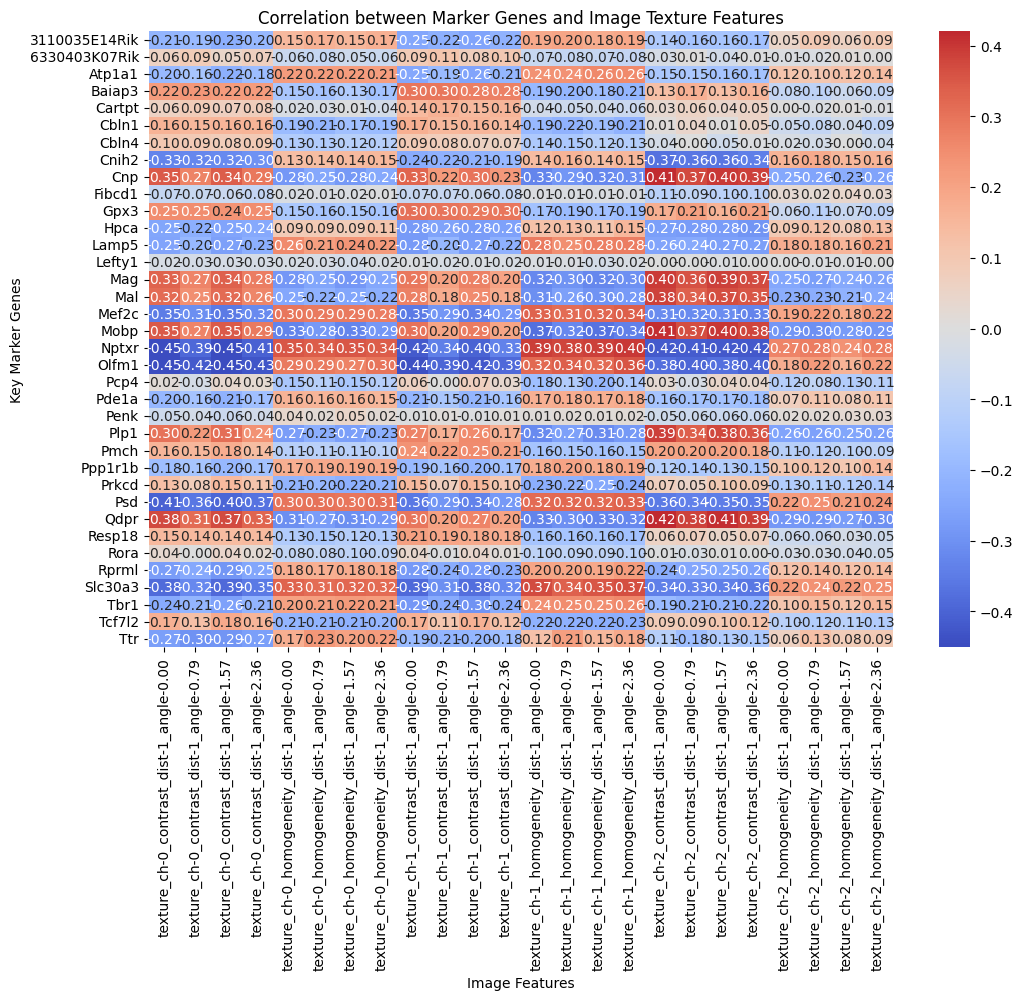

In [14]:
# 1. pick marker genes for correlation analysis
marker_genes = adata.uns['rank_genes_groups']['names'][:3] # 取每群前三名
genes_to_test = list(np.unique([item for sublist in marker_genes for item in sublist]))

# 2. extract gene expression data and image feature data
gene_data = pd.DataFrame(
    adata[:, genes_to_test].X.toarray() if hasattr(adata[:, genes_to_test].X, "toarray") else adata[:, genes_to_test].X,
    index=adata.obs_names,
    columns=genes_to_test
)
image_feats = adata.obsm['image_features']

# 3. calculate Pearson correlation matrix
# Combine the gene expression data and image features into one DataFrame for correlation calculation
combined_df = pd.concat([gene_data, image_feats], axis=1)
corr_matrix = combined_df.corr().loc[genes_to_test, image_feats.columns]

# 4. visualize in a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Correlation between Marker Genes and Image Texture Features")
plt.xlabel("Image Features")
plt.ylabel("Key Marker Genes")

plt.savefig("../results/gene_image_correlation_heatmap.png", dpi=300, bbox_inches='tight')

plt.show()

INFO     Creating graph using `grid` coordinates and `None` transform and `1` libraries.                           


100%|██████████| 100/100 [00:12<00:00,  7.71/s]


Top 5 Spatially Variable Genes: ['Mbp', 'Slc17a7', 'Nrgn', 'Cck', 'Itpka']


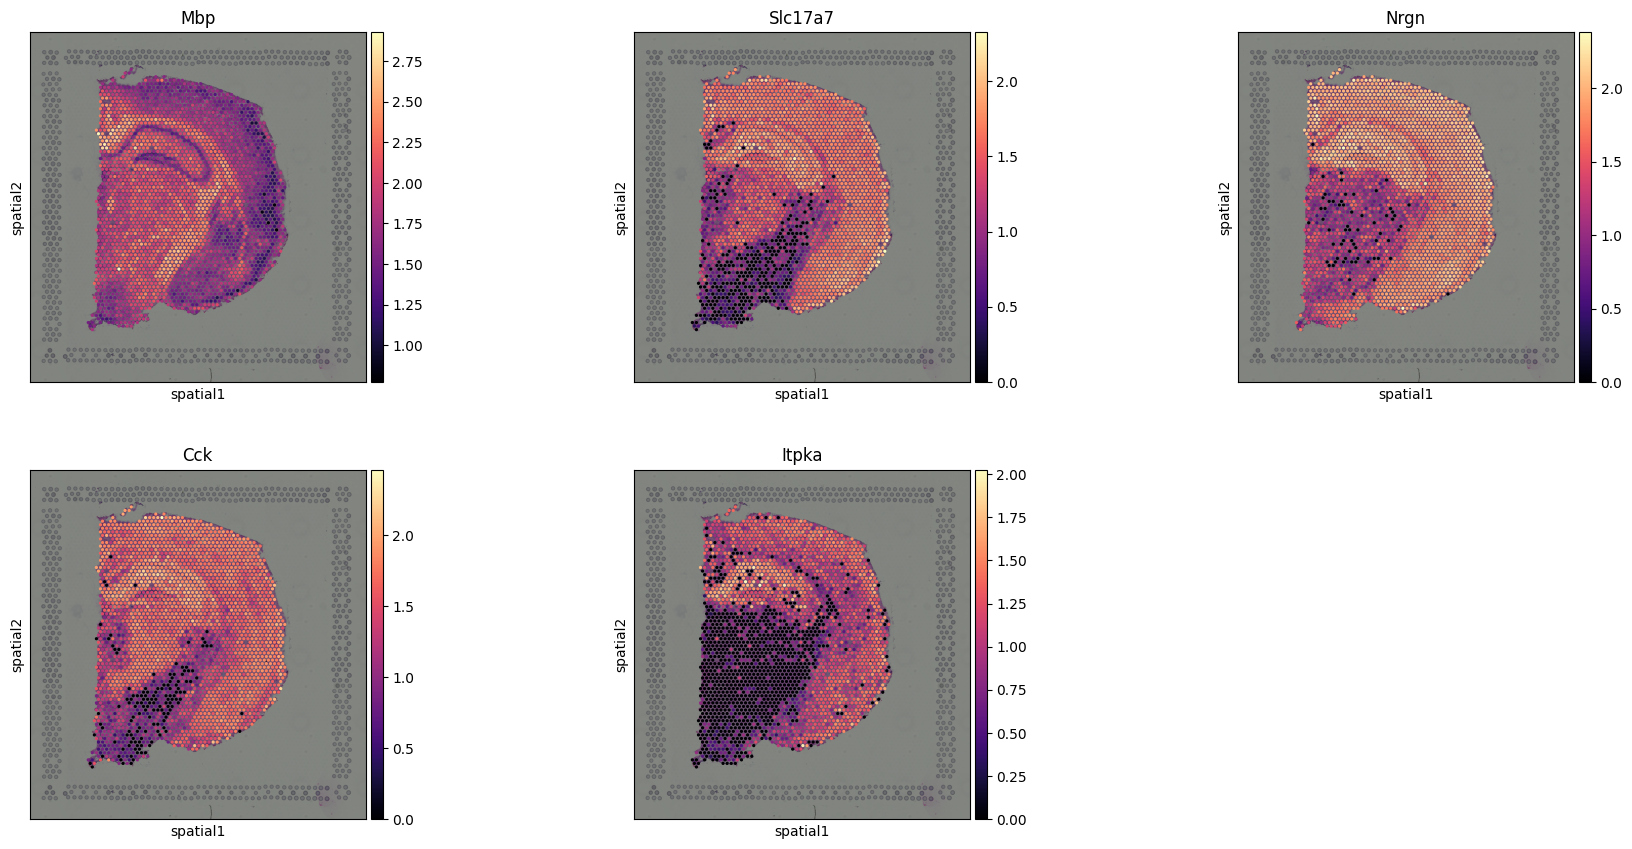

In [15]:
# 1. establish spatial neighbors graph
# This defines which Spots are physically neighboring
sq.gr.spatial_neighbors(adata)

# 2. calculate Moran's I statistic
# We compute this for the previously selected highly variable genes (HVGs) to find the most spatially structured genes
sq.gr.spatial_autocorr(
    adata,
    mode="moran",
    genes=adata.var_names,
    n_perms=100,      # permutation 100 times to ensure significance
    n_jobs=-1,
)

# 3. get top 5 spatially variable genes
top_svgs = adata.uns["moranI"].head(5).index.tolist()
print(f"Top 5 Spatially Variable Genes: {top_svgs}")

# 4. visualize: plot these spatial genes on the tissue section
sq.pl.spatial_scatter(
    adata,
    color=top_svgs[:6], 
    library_id=lib_id,
    img=True,
    img_res_key="hires",
    ncols=3,
    size=1.2,
    cmap="magma"     
)

plt.savefig("../results/spatial_topgenes.png", dpi=300, bbox_inches='tight')